In [4]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from rff.layers import GaussianEncoding #pip install random-fourier-features-pytorch
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
import os
import optuna
from optuna.trial import TrialState

In [5]:
# Run regardless if you do or do not have GPU so all tensors are moved to right location later on
if torch.cuda.is_available():
    device_in_use = torch.device("cuda")
    print("GPU is available and being used")
else:
    device_in_use = torch.device("cpu")
    print("GPU is not available, using CPU instead")

GPU is available and being used


# LOAD AND PROCESS DATA
**EXAMPLE WITH COVTYPE DATASET**
1. Standardize or perform quantile transformations to numerical/continuous features.
1. Wrap with Dataset and Dataloader.

In [6]:
df_train = pd.read_csv('/home/cscadmin/CyberResearch/CAT-Transformer/datasets/california/train.csv')
df_test = pd.read_csv('/home/cscadmin/CyberResearch/CAT-Transformer/datasets/california/test.csv')
df_val = pd.read_csv('/home/cscadmin/CyberResearch/CAT-Transformer/datasets/california/validation.csv') #READ FROM RIGHT SPOT

# df_train = pd.read_csv(r'C:\Users\smbm2\projects\CAT-Transformer\datasets\california\train.csv')
# df_test = pd.read_csv(r'C:\Users\smbm2\projects\CAT-Transformer\datasets\california\test.csv')
# df_val = pd.read_csv(r'C:\Users\smbm2\projects\CAT-Transformer\datasets\california\validation.csv') #READ FROM RIGHT SPOT

#Take a look at what the datasets look like initially to get an idea
df_train

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,2.8631,20.0,4.401210,1.076613,999.0,2.014113,32.79,-117.09
1,4.2026,24.0,5.617544,0.989474,731.0,2.564912,34.59,-120.14
2,3.1094,14.0,5.869565,1.094203,302.0,2.188406,39.26,-121.00
3,3.3068,52.0,4.801205,1.066265,1526.0,2.298193,37.77,-122.45
4,4.0791,11.0,5.878902,1.098493,4773.0,2.568891,33.17,-117.33
...,...,...,...,...,...,...,...,...
14442,6.3700,35.0,6.129032,0.926267,658.0,3.032258,33.78,-117.96
14443,3.0500,33.0,6.868597,1.269488,1753.0,3.904232,34.02,-117.43
14444,2.9344,36.0,3.986717,1.079696,1756.0,3.332068,34.03,-118.38
14445,5.7192,15.0,6.395349,1.067979,1777.0,3.178891,37.58,-121.96


In [7]:
#Take a look at the feature names
df_train.columns

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude'],
      dtype='object')

In [8]:
cont_columns = ['HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude']
target = ['MedInc']

#CHECKING TO MAKE SURE YOUR LIST IS CORRECT (NO NEED TO TOUCH)
yourlist = cont_columns + target
yourlist.sort()
oglist = list(df_train.columns)
oglist.sort()

assert(yourlist == oglist), "You may of spelled feature name wrong or you forgot to put on of them in the list"

In [9]:
#Getting the number of classes in your classification target
target_classes = [max(len(df_train[target].value_counts()), len(df_val[target].value_counts()),len(df_test[target].value_counts()))]
target_classes

[9851]

In [10]:
# Create a StandardScaler and fit it to the cont features
scaler = StandardScaler()
scaler.fit(df_train[cont_columns])

# Transform the training, test, and validation datasets
df_train[cont_columns] = scaler.transform(df_train[cont_columns])
df_test[cont_columns] = scaler.transform(df_test[cont_columns])
df_val[cont_columns] = scaler.transform(df_val[cont_columns])

In [11]:
class SingleTaskDataset(Dataset):
    def __init__(self, df : pd.DataFrame, num_columns,task1_column):
        self.n = df.shape[0]
        
        self.task1_labels = df[task1_column].astype(np.float32).values

        self.num = df[num_columns].astype(np.float32).values


    def __len__(self):
        return self.n
    
    def __getitem__(self, idx):
        # Retrieve features and labels from the dataframe using column names
        num_features = self.num[idx]
        labels_task1 = self.task1_labels[idx]

        return num_features, labels_task1

#Wrapping in Dataset
train_dataset = SingleTaskDataset(df_train, cont_columns, 'MedInc')
val_dataset = SingleTaskDataset(df_val, cont_columns, 'MedInc')
test_dataset = SingleTaskDataset(df_test, cont_columns, 'MedInc')

#This is a hyperparameter that is not tuned. Maybe mess with what makes sense here
#Also try looking to see what other papers have done
batch_size = 256

# Wrapping with DataLoader for easy batch extraction
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# MODEL AND HELPERS

1. All you should have to do is interact with Classifier()

In [12]:
# each task loss is scaled by its own learnable parameter, then regularization is applied 
class UncertaintyLoss(nn.Module):
    def __init__(self, num_tasks):
        super(UncertaintyLoss, self).__init__()
        self.num_tasks = num_tasks

        self.loss_fns = [nn.MSELoss() for x in range(num_tasks)] 

    def forward(self, predictions, labels_task1):

        #task 1
        target = labels_task1
        prediction = predictions
        loss_fn = self.loss_fns[0]
        task_loss = loss_fn(prediction, target)
        
        return task_loss
    
#All layers of the model
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(MultiHeadAttention, self).__init__()

        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads
        assert(self.head_dim * heads == embed_size), "Embed size needs to be div by heads"
        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys =nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.fc_out = nn.Linear(heads*self.head_dim, embed_size)


    def forward(self, values, keys, query):
        N = query.shape[0]
        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]

        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        queries = query.reshape(N, query_len, self.heads, self.head_dim)

        values = self.values(values)
        keys = self.keys(keys)
        queries = self.queries(queries)

        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])

        attention = torch.softmax(energy / (self.embed_size ** (1/2)), dim=3) #(batch_size, head_dim, #query_embeddings, #key_embeddings)

        # Calculate simplified attention scores
        avg_attention = attention.mean(dim=0)  # Average across batches
        # print("batch average", avg_attention.shape)
        avg_attention = avg_attention.mean(dim=0).squeeze(dim=0)
        # print("head average", avg_attention.shape)

        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(N, query_len, self.heads*self.head_dim) #(batch_size, n_features, embed_size)
        out = self.fc_out(out)

        return out, avg_attention
    
class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads, dropout, forward_expansion, pre_norm_on):
        super(TransformerBlock, self).__init__()

        self.pre_norm_on = pre_norm_on
        if self.pre_norm_on:
            self.pre_norm = nn.LayerNorm(embed_size)
        self.attention = MultiHeadAttention(embed_size, heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)

        self.feed_forward = nn.Sequential(nn.Linear(embed_size, forward_expansion*embed_size),
                                          nn.ReLU(),
                                          nn.Linear(forward_expansion*embed_size, embed_size)
                                          )
        self.dropout = nn.Dropout(dropout)

    def forward(self,value,key,query):
        if self.pre_norm_on:
            query = self.pre_norm(query)
            key = self.pre_norm(key)
            value = self.pre_norm(value)
            
        attention, avg_attention = self.attention(value, key, query)
        x = self.dropout(self.norm1(attention + query))
        forward = self.feed_forward(x)
        out = self.dropout(self.norm2(forward + x))
        return out, avg_attention
    
class DecoderBlock(nn.Module):
    def __init__(self, embed_size, heads, forward_expansion, dropout, pre_norm_on):
        super(DecoderBlock, self).__init__()

        self.attention = MultiHeadAttention(embed_size, heads)
        self.norm = nn.LayerNorm(embed_size)
        self.transformer_block = TransformerBlock(embed_size, heads, dropout, forward_expansion, pre_norm_on)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, value, key):
        out, avg_attention = self.transformer_block(value, key, x)

        return out, avg_attention

class Decoder(nn.Module):
    def __init__(self,
                 embed_size,
                 num_layers,
                 heads,
                 forward_expansion,
                 decoder_dropout,
                 pre_norm_on
    ):
        super(Decoder, self).__init__()

        self.layers = nn.ModuleList(
                [
                    DecoderBlock(
                        embed_size,
                        heads,
                        dropout=decoder_dropout,
                        forward_expansion=forward_expansion,
                        pre_norm_on=pre_norm_on
                    )
                    for _ in range(num_layers)
                ]
            )
        self.avg_attention = None

    def forward(self, class_embed, context):
        for layer in self.layers:
            # x is the classification embedding (CLS Token)
            # context are the feature embeddings that will be used as key and value
            x, self.avg_attention = layer(class_embed, context, context)
  
        return x 

class Embeddings(nn.Module):
    def __init__(self, sigma, embed_size, input_size, embedding_dropout, n_features, num_target_labels, rff_on):
        super(Embeddings, self).__init__()

        self.rff_on = rff_on

        if self.rff_on:
            self.rffs = nn.ModuleList([GaussianEncoding(sigma=sigma, input_size=input_size, encoded_size=embed_size//2) for _ in range(n_features)])
            self.dropout = nn.Dropout(embedding_dropout)
            self.mlp_in = embed_size
        else:
            self.mlp_in = input_size

        self.embeddings = nn.ModuleList([nn.Linear(in_features=self.mlp_in, out_features=embed_size) for _ in range(n_features)])

        # Classifcation Embeddings for each target label
        self.target_label_embeddings = nn.ModuleList([nn.Embedding(1, embed_size) for _ in range(num_target_labels)])


    def forward(self, x):
        x = x.unsqueeze(2) #(batch_size, n_features) -> (batch_size, n_features, 1)
        rff_vectors = []
        if self.rff_on:
            for i, r in enumerate(self.rffs):
                input = x[:,i,:]
                out = r(input)
                rff_vectors.append(out)
        
            x = torch.stack(rff_vectors, dim=1)
        
        embeddings = []
        for i, e in enumerate(self.embeddings):
            goin_in = x[:,i,:]
            goin_out = e(goin_in)
            embeddings.append(goin_out)

        target_label_embeddings_ = []
        for e in self.target_label_embeddings:
            input = torch.tensor([0], device=x.device)
            temp = e(input)
            temp = temp.repeat(x.size(0), 1)
            tmep = temp.unsqueeze(1)
            target_label_embeddings_.append(temp)

        class_embeddings = torch.stack(target_label_embeddings_, dim=1)

        context = torch.stack(embeddings, dim=1)

        return class_embeddings, context

class classificationHead(nn.Module):
    def __init__(self, embed_size, dropout, mlp_scale_classification, num_target_classes):
        super(classificationHead, self).__init__()
        
        #flattening the embeddings out so each sample in batch is represented with a 460 dimensional vector
        self.input = embed_size
        self.lin1 = nn.Linear(self.input, mlp_scale_classification*self.input)
        self.drop = nn.Dropout(dropout)
        self.lin2 = nn.Linear(mlp_scale_classification*self.input, mlp_scale_classification*self.input)
        self.lin3 = nn.Linear(mlp_scale_classification*self.input, self.input)
        self.lin4 = nn.Linear(self.input, 1)
        self.relu = nn.ReLU()
        self.initialize_weights()

    def initialize_weights(self): #he_initialization.
        torch.nn.init.kaiming_normal_(self.lin1.weight, nonlinearity='relu')
        torch.nn.init.zeros_(self.lin1.bias)

        torch.nn.init.kaiming_normal_(self.lin3.weight, nonlinearity='relu')
        torch.nn.init.zeros_(self.lin3.bias)

    def forward(self, x):

        x= torch.reshape(x, (-1, self.input))

        x = self.lin1(x)
        x = self.relu(x)
        x = self.drop(x)
        x = self.lin2(x)
        x = self.relu(x)
        x = self.drop(x)
        x = self.lin3(x)
        x = self.relu(x)
        x = self.drop(x)
        x = self.lin4(x)
  
        return x
    
# class classificationHead(nn.Module):
#     def __init__(self, embed_size, dropout, mlp_scale_classification, num_target_classes):
#         super(classificationHead, self).__init__()
        
#         #flattening the embeddings out so each sample in batch is represented with a 460 dimensional vector
#         self.input = embed_size
#         self.lin1 = nn.Linear(self.input, mlp_scale_classification*self.input)
#         self.drop = nn.Dropout(dropout)
#         self.lin2 = nn.Linear(mlp_scale_classification*self.input, mlp_scale_classification*self.input)
#         self.lin3 = nn.Linear(mlp_scale_classification*self.input, self.input)
#         self.lin4 = nn.Linear(self.input, num_target_classes)
#         self.relu = nn.ReLU()
#         self.initialize_weights()

#     def initialize_weights(self): #he_initialization.
#         torch.nn.init.kaiming_normal_(self.lin1.weight, nonlinearity='relu')
#         torch.nn.init.zeros_(self.lin1.bias)

#         torch.nn.init.kaiming_normal_(self.lin3.weight, nonlinearity='relu')
#         torch.nn.init.zeros_(self.lin3.bias)

#     def forward(self, x):

#         x= torch.reshape(x, (-1, self.input))

#         x = self.lin1(x)
#         x = self.relu(x)
#         x = self.drop(x)
#         x = self.lin2(x)
#         x = self.relu(x)
#         x = self.drop(x)
#         x = self.lin3(x)
#         x = self.relu(x)
#         x = self.drop(x)
#         x = self.lin4(x)
  
#         return x


# DEFAULT PARAMETERS SET UP FOR VPN DATASET. BE CAREFUL AND MAKE SURE YOU SET THEM UP HOW YOU WANT.
class Classifier(nn.Module):
    def __init__(self, 
                 rff_on = False,
                 sigma=4,
                 embed_size=20,
                 input_size=1,
                 embedding_dropout = 0,
                 n_features=23, # YOU WILL PROBABLY NEED TO CHANGE
                 num_layers=1,
                 heads=1,
                 forward_expansion=4, # Determines how wide the MLP is in the encoder. Its a scaling factor. 
                 decoder_dropout=0,
                 classification_dropout = 0,
                 pre_norm_on = False,
                 mlp_scale_classification = 4,
                 targets_classes : list=  [3,8]
                 ):
        super(Classifier, self).__init__()

        self.embeddings = Embeddings(rff_on=rff_on, sigma=sigma, embed_size=embed_size, input_size=input_size, embedding_dropout=embedding_dropout, n_features=n_features, num_target_labels=len(targets_classes))
        self.decoder = Decoder(embed_size=embed_size, num_layers=num_layers, heads=heads, forward_expansion=forward_expansion, decoder_dropout=decoder_dropout, pre_norm_on=pre_norm_on)
        self.classifying_heads = nn.ModuleList([classificationHead(embed_size=embed_size, dropout=classification_dropout, mlp_scale_classification=mlp_scale_classification, num_target_classes=x) for x in targets_classes])
        
    def forward(self, x):
        class_embed, context = self.embeddings(x)

        x = self.decoder(class_embed, context)
        
        probability_dist_raw = []
        for i, e in enumerate(self.classifying_heads):
            input = x[:, i,:]
            output = e(input)
            probability_dist_raw.append(output)
        
        return probability_dist_raw

# Training and Testing Loops
def train(dataloader, model, loss_function, optimizer, device_in_use):
    model.train()

    total_loss = 0
    total_r2_score = 0
    root_mean_squared_error_total = 0

    for (features, labels_task1) in dataloader:
        features, labels_task1 = features.to(device_in_use), labels_task1.to(device_in_use)

        task_predictions = model(features)

        loss = loss_function(task_predictions[0].squeeze(1), labels_task1)
        total_loss += loss.item()
        
        # Calculate R^2 score for the regression task
        r2 = r2_score_manual(labels_task1, task_predictions[0].squeeze(1))
        total_r2_score += r2

        # Calculate RMSE score for the regression task
        rmse_value = rmse(labels_task1, task_predictions[0].squeeze(1))
        root_mean_squared_error_total+=rmse_value

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    avg_loss = total_loss / len(dataloader)
    avg_r2_score = total_r2_score / len(dataloader)
    avg_rmse_score = root_mean_squared_error_total / len(dataloader)

    return avg_loss, avg_r2_score, avg_rmse_score

def test(dataloader, model, loss_function, device_in_use):
  model.eval()
  total_loss = 0
  
  total_loss = 0
  total_r2_score = 0
  root_mean_squared_error_total = 0

  with torch.no_grad():
    for (features,labels_task1) in dataloader:
        features, labels_task1 = features.to(device_in_use), labels_task1.to(device_in_use)

        task_predictions = model(features)

        loss = loss_function(task_predictions[0].squeeze(1), labels_task1)
        total_loss += loss.item()
        
        # Calculate R^2 score for the regression task
        r2 = r2_score_manual(labels_task1, task_predictions[0].squeeze(1))
        total_r2_score += r2
        
        # Calculate RMSE score for the regression task
        rmse_value = rmse(labels_task1, task_predictions[0].squeeze(1))
        root_mean_squared_error_total+=rmse_value

    avg_loss = total_loss / len(dataloader)
    avg_r2_score = total_r2_score / len(dataloader)
    avg_rmse_score = root_mean_squared_error_total / len(dataloader)

    return avg_loss, avg_r2_score, avg_rmse_score

def format_metric(value): # Used to format the metrics output
    return f"{value:.4f}"

def r2_score_manual(y_true, y_pred):
    # Calculate the mean of true labels
    y_mean = torch.mean(y_true)

    # Calculate the total sum of squares
    total_ss = torch.sum((y_true - y_mean)**2)

    # Calculate the residual sum of squares
    residual_ss = torch.sum((y_true - y_pred)**2)

    # Calculate R-squared
    r2 = 1 - (residual_ss / total_ss)

    return r2.item()  # Convert to a Python float

def rmse(y_true, y_pred):
    # Calculate the squared differences
    squared_diff = (y_true - y_pred)**2

    # Calculate the mean of the squared differences
    mean_squared_diff = torch.mean(squared_diff)

    # Calculate the square root to obtain RMSE
    rmse = torch.sqrt(mean_squared_diff)

    return rmse.item()  # Convert to a Python float

# RUN EXPERIMENTS

1. Using Optuna to optimize CAT-Transformers hyperparameters for your dataset

In [16]:
# Define the early stopping mechanism
class EarlyStopping:
    def __init__(self, patience=5):
        self.patience = patience
        self.counter = 0
        self.best_metric = float('-inf')
        self.early_stop = False

    def __call__(self, metric):
        if metric > self.best_metric:
            self.best_metric = metric
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# Function to log results to a text file
def log_to_file(filename, text):
    with open(filename, 'a') as f:
        f.write(text + '\n')

def objective(trial):
    trial_number = trial.number

    # Define hyperparameters to search over
    sigma = trial.suggest_categorical('sigma', [.001, 0.1, 1, 2, 3, 5, 10])
    num_layers = trial.suggest_int('num_layers', 1, 2)
    # Ensure that embed_size is divisible by num_layers
    embed_size = trial.suggest_categorical("embed_size", [50, 60, 70, 80, 90, 100, 120, 140, 160])
    heads = trial.suggest_categorical("heads", [1, 5, 10])
    forward_expansion = trial.suggest_int('forward_expansion', 1, 8)
    prenorm_on = trial.suggest_categorical('prenorm_on', [True, False])
    mlp_scale_classification = trial.suggest_int('mlp_scale_classification', 1, 8)
    embedding_dropout = trial.suggest_categorical('embedding_dropout', [0, .1, .2, .5])
    decoder_dropout = trial.suggest_categorical('decoder_dropout', [0,.1,.2,.5])
    classification_dropout = trial.suggest_categorical('class_drop', [0,.1,.2,.5])

    learning_rate = trial.suggest_categorical('learning_rate', [0.0001, 0.001, 0.01])

    num_epochs = 100


    # Create your model with the sampled hyperparameters
    model = Classifier(
        n_features=len(cont_columns),
        targets_classes=[0],
        rff_on=True,
        sigma=sigma,
        embed_size=embed_size,
        num_layers=num_layers,
        heads=heads,
        forward_expansion=forward_expansion,
        pre_norm_on=prenorm_on,
        mlp_scale_classification=mlp_scale_classification,
        embedding_dropout=embedding_dropout,
        decoder_dropout=decoder_dropout,
        classification_dropout=classification_dropout
    ).to(device_in_use)

    # Define loss function and optimizer
    loss_function = UncertaintyLoss(1)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Initialize early stopping
    early_stopping = EarlyStopping(patience=10)  # Adjust patience as needed

    # Training loop with a large number of epochs
    for epoch in range(num_epochs):
        train_loss, r2_train, rmse_train = train(train_dataloader, model, loss_function, optimizer, device_in_use)
        
        # Validation loop
        test_loss, r2_test, rmse_test = test(val_dataloader, model, loss_function, device_in_use)
        
        # Check if we should early stop based on validation rmse
        if early_stopping(rmse_test):
            break
    
    # Log the final test accuracy for this trial to a shared log file
    final_log = f"Trial {trial_number} completed. Validation RMSE = {rmse_test:.4f}"
    log_to_file('all_trials_log.txt', final_log)

    # Return the test accuracy as the objective to optimize
    return rmse_test

In [17]:
# Set the number of optimization trials
num_trials = 100

# Create an Optuna study
study = optuna.create_study(direction='minimize')  # Maximize validation accuracy

# Start the optimization process
study.optimize(objective, n_trials=num_trials, show_progress_bar=True)

# Get the best hyperparameters and the validation accuracy at the point of early stopping
best_params = study.best_params
best_val_rmse = study.best_value

print("Best Hyperparameters:", best_params)
print("Best Validation RMSE (at Early Stopping):", best_val_rmse)

[I 2023-10-25 10:14:44,746] A new study created in memory with name: no-name-286ad601-56e9-4566-b5e9-cea403e1c5ec
Best trial: 0. Best value: 1.57955:   1%|          | 1/100 [01:43<2:50:56, 103.60s/it]

[I 2023-10-25 10:16:28,350] Trial 0 finished with value: 1.579547460262592 and parameters: {'sigma': 2, 'num_layers': 2, 'embed_size': 140, 'heads': 1, 'forward_expansion': 6, 'prenorm_on': False, 'mlp_scale_classification': 4, 'embedding_dropout': 0.2, 'decoder_dropout': 0.5, 'class_drop': 0.1, 'learning_rate': 0.001}. Best is trial 0 with value: 1.579547460262592.


Best trial: 1. Best value: 0.943888:   2%|▏         | 2/100 [03:25<2:47:48, 102.74s/it]

[I 2023-10-25 10:18:10,480] Trial 1 finished with value: 0.9438884487518897 and parameters: {'sigma': 3, 'num_layers': 2, 'embed_size': 80, 'heads': 5, 'forward_expansion': 4, 'prenorm_on': False, 'mlp_scale_classification': 3, 'embedding_dropout': 0.5, 'decoder_dropout': 0, 'class_drop': 0.2, 'learning_rate': 0.001}. Best is trial 1 with value: 0.9438884487518897.


Best trial: 2. Best value: 0.891359:   3%|▎         | 3/100 [05:15<2:51:08, 105.86s/it]

[I 2023-10-25 10:20:00,056] Trial 2 finished with value: 0.8913589670107915 and parameters: {'sigma': 2, 'num_layers': 2, 'embed_size': 50, 'heads': 5, 'forward_expansion': 6, 'prenorm_on': True, 'mlp_scale_classification': 7, 'embedding_dropout': 0, 'decoder_dropout': 0, 'class_drop': 0.2, 'learning_rate': 0.01}. Best is trial 2 with value: 0.8913589670107915.


Best trial: 2. Best value: 0.891359:   4%|▍         | 4/100 [06:51<2:43:25, 102.14s/it]

[I 2023-10-25 10:21:36,482] Trial 3 finished with value: 1.4150457198803241 and parameters: {'sigma': 10, 'num_layers': 1, 'embed_size': 90, 'heads': 1, 'forward_expansion': 1, 'prenorm_on': True, 'mlp_scale_classification': 5, 'embedding_dropout': 0.5, 'decoder_dropout': 0.2, 'class_drop': 0, 'learning_rate': 0.0001}. Best is trial 2 with value: 0.8913589670107915.


Best trial: 2. Best value: 0.891359:   5%|▌         | 5/100 [08:35<2:42:23, 102.56s/it]

[I 2023-10-25 10:23:19,804] Trial 4 finished with value: 0.9954944161268381 and parameters: {'sigma': 5, 'num_layers': 2, 'embed_size': 140, 'heads': 5, 'forward_expansion': 6, 'prenorm_on': False, 'mlp_scale_classification': 1, 'embedding_dropout': 0.1, 'decoder_dropout': 0.5, 'class_drop': 0.5, 'learning_rate': 0.001}. Best is trial 2 with value: 0.8913589670107915.


Best trial: 2. Best value: 0.891359:   6%|▌         | 6/100 [10:16<2:40:11, 102.25s/it]

[I 2023-10-25 10:25:01,450] Trial 5 finished with value: 0.9526558059912461 and parameters: {'sigma': 1, 'num_layers': 2, 'embed_size': 80, 'heads': 5, 'forward_expansion': 4, 'prenorm_on': False, 'mlp_scale_classification': 2, 'embedding_dropout': 0.1, 'decoder_dropout': 0, 'class_drop': 0, 'learning_rate': 0.001}. Best is trial 2 with value: 0.8913589670107915.


Best trial: 2. Best value: 0.891359:   7%|▋         | 7/100 [11:59<2:38:40, 102.37s/it]

[I 2023-10-25 10:26:44,067] Trial 6 finished with value: 2.4008707266587477 and parameters: {'sigma': 3, 'num_layers': 1, 'embed_size': 160, 'heads': 5, 'forward_expansion': 5, 'prenorm_on': True, 'mlp_scale_classification': 8, 'embedding_dropout': 0.5, 'decoder_dropout': 0.5, 'class_drop': 0.5, 'learning_rate': 0.0001}. Best is trial 2 with value: 0.8913589670107915.


Best trial: 2. Best value: 0.891359:   8%|▊         | 8/100 [13:33<2:32:52, 99.70s/it] 

[I 2023-10-25 10:28:18,040] Trial 7 finished with value: 0.9211305838364822 and parameters: {'sigma': 2, 'num_layers': 1, 'embed_size': 70, 'heads': 5, 'forward_expansion': 7, 'prenorm_on': False, 'mlp_scale_classification': 1, 'embedding_dropout': 0.2, 'decoder_dropout': 0.5, 'class_drop': 0.2, 'learning_rate': 0.01}. Best is trial 2 with value: 0.8913589670107915.


Best trial: 2. Best value: 0.891359:   9%|▉         | 9/100 [15:14<2:31:41, 100.01s/it]

[I 2023-10-25 10:29:58,751] Trial 8 finished with value: 1.1274813505319448 and parameters: {'sigma': 10, 'num_layers': 2, 'embed_size': 160, 'heads': 10, 'forward_expansion': 5, 'prenorm_on': False, 'mlp_scale_classification': 8, 'embedding_dropout': 0.2, 'decoder_dropout': 0.1, 'class_drop': 0.1, 'learning_rate': 0.01}. Best is trial 2 with value: 0.8913589670107915.


Best trial: 2. Best value: 0.891359:  10%|█         | 10/100 [16:46<2:26:24, 97.61s/it]

[I 2023-10-25 10:31:30,968] Trial 9 finished with value: 1.7663201827269335 and parameters: {'sigma': 5, 'num_layers': 1, 'embed_size': 140, 'heads': 1, 'forward_expansion': 8, 'prenorm_on': False, 'mlp_scale_classification': 1, 'embedding_dropout': 0, 'decoder_dropout': 0.5, 'class_drop': 0, 'learning_rate': 0.0001}. Best is trial 2 with value: 0.8913589670107915.


Best trial: 2. Best value: 0.891359:  11%|█         | 11/100 [18:32<2:28:31, 100.13s/it]

[I 2023-10-25 10:33:16,824] Trial 10 finished with value: 0.8974522856565622 and parameters: {'sigma': 0.1, 'num_layers': 2, 'embed_size': 50, 'heads': 10, 'forward_expansion': 2, 'prenorm_on': True, 'mlp_scale_classification': 6, 'embedding_dropout': 0, 'decoder_dropout': 0, 'class_drop': 0.2, 'learning_rate': 0.01}. Best is trial 2 with value: 0.8913589670107915.


Best trial: 2. Best value: 0.891359:  12%|█▏        | 12/100 [20:19<2:29:55, 102.22s/it]

[I 2023-10-25 10:35:03,836] Trial 11 finished with value: 0.9787112291042621 and parameters: {'sigma': 0.1, 'num_layers': 2, 'embed_size': 50, 'heads': 10, 'forward_expansion': 2, 'prenorm_on': True, 'mlp_scale_classification': 6, 'embedding_dropout': 0, 'decoder_dropout': 0, 'class_drop': 0.2, 'learning_rate': 0.01}. Best is trial 2 with value: 0.8913589670107915.


Best trial: 2. Best value: 0.891359:  13%|█▎        | 13/100 [22:04<2:29:40, 103.23s/it]

[I 2023-10-25 10:36:49,368] Trial 12 finished with value: 1.0326063082768366 and parameters: {'sigma': 0.001, 'num_layers': 2, 'embed_size': 50, 'heads': 10, 'forward_expansion': 3, 'prenorm_on': True, 'mlp_scale_classification': 6, 'embedding_dropout': 0, 'decoder_dropout': 0, 'class_drop': 0.2, 'learning_rate': 0.01}. Best is trial 2 with value: 0.8913589670107915.


Best trial: 13. Best value: 0.881499:  14%|█▍        | 14/100 [23:50<2:28:56, 103.91s/it]

[I 2023-10-25 10:38:34,857] Trial 13 finished with value: 0.8814985797955439 and parameters: {'sigma': 0.1, 'num_layers': 2, 'embed_size': 50, 'heads': 10, 'forward_expansion': 1, 'prenorm_on': True, 'mlp_scale_classification': 7, 'embedding_dropout': 0, 'decoder_dropout': 0, 'class_drop': 0.2, 'learning_rate': 0.01}. Best is trial 13 with value: 0.8814985797955439.


Best trial: 13. Best value: 0.881499:  15%|█▌        | 15/100 [25:39<2:29:40, 105.65s/it]

[I 2023-10-25 10:40:24,536] Trial 14 finished with value: 1.0105721308634832 and parameters: {'sigma': 2, 'num_layers': 2, 'embed_size': 60, 'heads': 10, 'forward_expansion': 1, 'prenorm_on': True, 'mlp_scale_classification': 7, 'embedding_dropout': 0, 'decoder_dropout': 0.1, 'class_drop': 0.2, 'learning_rate': 0.01}. Best is trial 13 with value: 0.8814985797955439.


Best trial: 15. Best value: 0.864968:  16%|█▌        | 16/100 [27:27<2:28:48, 106.29s/it]

[I 2023-10-25 10:42:12,329] Trial 15 finished with value: 0.8649675433452313 and parameters: {'sigma': 0.1, 'num_layers': 2, 'embed_size': 120, 'heads': 5, 'forward_expansion': 8, 'prenorm_on': True, 'mlp_scale_classification': 7, 'embedding_dropout': 0, 'decoder_dropout': 0.2, 'class_drop': 0.2, 'learning_rate': 0.01}. Best is trial 15 with value: 0.8649675433452313.


Best trial: 15. Best value: 0.864968:  17%|█▋        | 17/100 [29:11<2:26:12, 105.69s/it]

[I 2023-10-25 10:43:56,611] Trial 16 finished with value: 0.8689053975618802 and parameters: {'sigma': 0.1, 'num_layers': 2, 'embed_size': 120, 'heads': 10, 'forward_expansion': 8, 'prenorm_on': True, 'mlp_scale_classification': 5, 'embedding_dropout': 0, 'decoder_dropout': 0.2, 'class_drop': 0.2, 'learning_rate': 0.01}. Best is trial 15 with value: 0.8649675433452313.


Best trial: 15. Best value: 0.864968:  18%|█▊        | 18/100 [30:53<2:22:49, 104.51s/it]

[I 2023-10-25 10:45:38,368] Trial 17 finished with value: 0.8654124507537255 and parameters: {'sigma': 0.1, 'num_layers': 1, 'embed_size': 120, 'heads': 5, 'forward_expansion': 8, 'prenorm_on': True, 'mlp_scale_classification': 4, 'embedding_dropout': 0, 'decoder_dropout': 0.2, 'class_drop': 0.5, 'learning_rate': 0.01}. Best is trial 15 with value: 0.8649675433452313.


Best trial: 15. Best value: 0.864968:  19%|█▉        | 19/100 [32:37<2:20:38, 104.18s/it]

[I 2023-10-25 10:47:21,797] Trial 18 finished with value: 1.0576759989445026 and parameters: {'sigma': 0.1, 'num_layers': 1, 'embed_size': 120, 'heads': 5, 'forward_expansion': 7, 'prenorm_on': True, 'mlp_scale_classification': 4, 'embedding_dropout': 0.1, 'decoder_dropout': 0.2, 'class_drop': 0.5, 'learning_rate': 0.01}. Best is trial 15 with value: 0.8649675433452313.


Best trial: 15. Best value: 0.864968:  20%|██        | 20/100 [34:20<2:18:37, 103.97s/it]

[I 2023-10-25 10:49:05,265] Trial 19 finished with value: 1.4797649750342736 and parameters: {'sigma': 1, 'num_layers': 1, 'embed_size': 100, 'heads': 5, 'forward_expansion': 8, 'prenorm_on': True, 'mlp_scale_classification': 3, 'embedding_dropout': 0, 'decoder_dropout': 0.2, 'class_drop': 0.5, 'learning_rate': 0.0001}. Best is trial 15 with value: 0.8649675433452313.


Best trial: 15. Best value: 0.864968:  21%|██        | 21/100 [36:03<2:16:22, 103.57s/it]

[I 2023-10-25 10:50:47,909] Trial 20 finished with value: 1.895534405341515 and parameters: {'sigma': 0.001, 'num_layers': 1, 'embed_size': 120, 'heads': 5, 'forward_expansion': 7, 'prenorm_on': True, 'mlp_scale_classification': 3, 'embedding_dropout': 0, 'decoder_dropout': 0.2, 'class_drop': 0.5, 'learning_rate': 0.01}. Best is trial 15 with value: 0.8649675433452313.


Best trial: 21. Best value: 0.84955:  22%|██▏       | 22/100 [37:42<2:13:02, 102.35s/it] 

[I 2023-10-25 10:52:27,395] Trial 21 finished with value: 0.8495504581011258 and parameters: {'sigma': 0.1, 'num_layers': 1, 'embed_size': 120, 'heads': 5, 'forward_expansion': 8, 'prenorm_on': True, 'mlp_scale_classification': 5, 'embedding_dropout': 0, 'decoder_dropout': 0.2, 'class_drop': 0.1, 'learning_rate': 0.01}. Best is trial 21 with value: 0.8495504581011258.


Best trial: 22. Best value: 0.845318:  23%|██▎       | 23/100 [39:26<2:11:54, 102.78s/it]

[I 2023-10-25 10:54:11,199] Trial 22 finished with value: 0.8453183449231662 and parameters: {'sigma': 0.1, 'num_layers': 1, 'embed_size': 120, 'heads': 5, 'forward_expansion': 8, 'prenorm_on': True, 'mlp_scale_classification': 5, 'embedding_dropout': 0, 'decoder_dropout': 0.2, 'class_drop': 0.1, 'learning_rate': 0.01}. Best is trial 22 with value: 0.8453183449231662.


Best trial: 22. Best value: 0.845318:  24%|██▍       | 24/100 [41:06<2:09:15, 102.04s/it]

[I 2023-10-25 10:55:51,516] Trial 23 finished with value: 0.8754452696213355 and parameters: {'sigma': 0.1, 'num_layers': 1, 'embed_size': 120, 'heads': 5, 'forward_expansion': 7, 'prenorm_on': True, 'mlp_scale_classification': 5, 'embedding_dropout': 0, 'decoder_dropout': 0.2, 'class_drop': 0.1, 'learning_rate': 0.01}. Best is trial 22 with value: 0.8453183449231662.


Best trial: 22. Best value: 0.845318:  25%|██▌       | 25/100 [42:46<2:06:31, 101.22s/it]

[I 2023-10-25 10:57:30,832] Trial 24 finished with value: 0.8731918334960938 and parameters: {'sigma': 0.1, 'num_layers': 1, 'embed_size': 120, 'heads': 5, 'forward_expansion': 8, 'prenorm_on': True, 'mlp_scale_classification': 6, 'embedding_dropout': 0, 'decoder_dropout': 0.2, 'class_drop': 0.1, 'learning_rate': 0.01}. Best is trial 22 with value: 0.8453183449231662.


Best trial: 22. Best value: 0.845318:  26%|██▌       | 26/100 [44:27<2:04:44, 101.14s/it]

[I 2023-10-25 10:59:11,771] Trial 25 finished with value: 0.8612062289164617 and parameters: {'sigma': 0.1, 'num_layers': 1, 'embed_size': 120, 'heads': 5, 'forward_expansion': 7, 'prenorm_on': True, 'mlp_scale_classification': 5, 'embedding_dropout': 0, 'decoder_dropout': 0.2, 'class_drop': 0.1, 'learning_rate': 0.01}. Best is trial 22 with value: 0.8453183449231662.


Best trial: 22. Best value: 0.845318:  27%|██▋       | 27/100 [46:01<2:00:41, 99.19s/it] 

[I 2023-10-25 11:00:46,427] Trial 26 finished with value: 1.906200069647569 and parameters: {'sigma': 0.1, 'num_layers': 1, 'embed_size': 60, 'heads': 1, 'forward_expansion': 7, 'prenorm_on': True, 'mlp_scale_classification': 5, 'embedding_dropout': 0.2, 'decoder_dropout': 0.2, 'class_drop': 0.1, 'learning_rate': 0.01}. Best is trial 22 with value: 0.8453183449231662.


Best trial: 22. Best value: 0.845318:  28%|██▊       | 28/100 [47:44<2:00:30, 100.42s/it]

[I 2023-10-25 11:02:29,706] Trial 27 finished with value: 0.9158270634137667 and parameters: {'sigma': 0.1, 'num_layers': 1, 'embed_size': 70, 'heads': 5, 'forward_expansion': 6, 'prenorm_on': True, 'mlp_scale_classification': 4, 'embedding_dropout': 0.1, 'decoder_dropout': 0.1, 'class_drop': 0.1, 'learning_rate': 0.01}. Best is trial 22 with value: 0.8453183449231662.


Best trial: 22. Best value: 0.845318:  29%|██▉       | 29/100 [49:27<1:59:36, 101.08s/it]

[I 2023-10-25 11:04:12,316] Trial 28 finished with value: 1.3235201560533965 and parameters: {'sigma': 10, 'num_layers': 1, 'embed_size': 90, 'heads': 5, 'forward_expansion': 7, 'prenorm_on': True, 'mlp_scale_classification': 5, 'embedding_dropout': 0.5, 'decoder_dropout': 0.2, 'class_drop': 0.1, 'learning_rate': 0.0001}. Best is trial 22 with value: 0.8453183449231662.


Best trial: 22. Best value: 0.845318:  30%|███       | 30/100 [51:07<1:57:36, 100.81s/it]

[I 2023-10-25 11:05:52,507] Trial 29 finished with value: 1.1271171386425312 and parameters: {'sigma': 0.001, 'num_layers': 1, 'embed_size': 100, 'heads': 1, 'forward_expansion': 5, 'prenorm_on': True, 'mlp_scale_classification': 3, 'embedding_dropout': 0.2, 'decoder_dropout': 0.2, 'class_drop': 0.1, 'learning_rate': 0.001}. Best is trial 22 with value: 0.8453183449231662.


Best trial: 22. Best value: 0.845318:  31%|███       | 31/100 [52:48<1:55:55, 100.81s/it]

[I 2023-10-25 11:07:33,315] Trial 30 finished with value: 1.0229045702860906 and parameters: {'sigma': 5, 'num_layers': 1, 'embed_size': 120, 'heads': 5, 'forward_expansion': 6, 'prenorm_on': True, 'mlp_scale_classification': 4, 'embedding_dropout': 0, 'decoder_dropout': 0.2, 'class_drop': 0.1, 'learning_rate': 0.001}. Best is trial 22 with value: 0.8453183449231662.


Best trial: 22. Best value: 0.845318:  32%|███▏      | 32/100 [54:24<1:52:39, 99.41s/it] 

[I 2023-10-25 11:09:09,450] Trial 31 finished with value: 0.8464146852493286 and parameters: {'sigma': 0.1, 'num_layers': 1, 'embed_size': 120, 'heads': 5, 'forward_expansion': 8, 'prenorm_on': True, 'mlp_scale_classification': 6, 'embedding_dropout': 0, 'decoder_dropout': 0.2, 'class_drop': 0.1, 'learning_rate': 0.01}. Best is trial 22 with value: 0.8453183449231662.


Best trial: 22. Best value: 0.845318:  33%|███▎      | 33/100 [56:07<1:52:15, 100.53s/it]

[I 2023-10-25 11:10:52,602] Trial 32 finished with value: 0.8843777775764465 and parameters: {'sigma': 0.1, 'num_layers': 1, 'embed_size': 120, 'heads': 5, 'forward_expansion': 8, 'prenorm_on': True, 'mlp_scale_classification': 6, 'embedding_dropout': 0, 'decoder_dropout': 0.2, 'class_drop': 0.1, 'learning_rate': 0.01}. Best is trial 22 with value: 0.8453183449231662.


Best trial: 22. Best value: 0.845318:  34%|███▍      | 34/100 [57:49<1:50:49, 100.74s/it]

[I 2023-10-25 11:12:33,838] Trial 33 finished with value: 0.9042230156751779 and parameters: {'sigma': 3, 'num_layers': 1, 'embed_size': 120, 'heads': 5, 'forward_expansion': 7, 'prenorm_on': True, 'mlp_scale_classification': 5, 'embedding_dropout': 0, 'decoder_dropout': 0.2, 'class_drop': 0.1, 'learning_rate': 0.01}. Best is trial 22 with value: 0.8453183449231662.


Best trial: 22. Best value: 0.845318:  35%|███▌      | 35/100 [59:28<1:48:42, 100.35s/it]

[I 2023-10-25 11:14:13,269] Trial 34 finished with value: 0.9508700095690213 and parameters: {'sigma': 0.1, 'num_layers': 1, 'embed_size': 80, 'heads': 5, 'forward_expansion': 8, 'prenorm_on': True, 'mlp_scale_classification': 6, 'embedding_dropout': 0.5, 'decoder_dropout': 0.2, 'class_drop': 0.1, 'learning_rate': 0.01}. Best is trial 22 with value: 0.8453183449231662.


Best trial: 22. Best value: 0.845318:  36%|███▌      | 36/100 [1:01:04<1:45:46, 99.16s/it] 

[I 2023-10-25 11:15:49,653] Trial 35 finished with value: 0.9646786772287809 and parameters: {'sigma': 1, 'num_layers': 1, 'embed_size': 120, 'heads': 5, 'forward_expansion': 6, 'prenorm_on': False, 'mlp_scale_classification': 5, 'embedding_dropout': 0, 'decoder_dropout': 0.2, 'class_drop': 0.1, 'learning_rate': 0.01}. Best is trial 22 with value: 0.8453183449231662.


Best trial: 22. Best value: 0.845318:  37%|███▋      | 37/100 [1:02:44<1:44:13, 99.26s/it]

[I 2023-10-25 11:17:29,153] Trial 36 finished with value: 0.9604285496931809 and parameters: {'sigma': 0.1, 'num_layers': 1, 'embed_size': 120, 'heads': 1, 'forward_expansion': 7, 'prenorm_on': True, 'mlp_scale_classification': 7, 'embedding_dropout': 0, 'decoder_dropout': 0.1, 'class_drop': 0.1, 'learning_rate': 0.001}. Best is trial 22 with value: 0.8453183449231662.


Best trial: 22. Best value: 0.845318:  38%|███▊      | 38/100 [1:04:21<1:41:50, 98.55s/it]

[I 2023-10-25 11:19:06,059] Trial 37 finished with value: 0.9659987046168401 and parameters: {'sigma': 3, 'num_layers': 1, 'embed_size': 90, 'heads': 5, 'forward_expansion': 8, 'prenorm_on': True, 'mlp_scale_classification': 4, 'embedding_dropout': 0.1, 'decoder_dropout': 0.2, 'class_drop': 0, 'learning_rate': 0.01}. Best is trial 22 with value: 0.8453183449231662.


Best trial: 22. Best value: 0.845318:  39%|███▉      | 39/100 [1:05:59<1:39:56, 98.30s/it]

[I 2023-10-25 11:20:43,766] Trial 38 finished with value: 2.076985405041621 and parameters: {'sigma': 2, 'num_layers': 1, 'embed_size': 140, 'heads': 5, 'forward_expansion': 6, 'prenorm_on': False, 'mlp_scale_classification': 5, 'embedding_dropout': 0.5, 'decoder_dropout': 0.5, 'class_drop': 0.1, 'learning_rate': 0.0001}. Best is trial 22 with value: 0.8453183449231662.


Best trial: 22. Best value: 0.845318:  40%|████      | 40/100 [1:07:37<1:38:27, 98.45s/it]

[I 2023-10-25 11:22:22,567] Trial 39 finished with value: 1.1226018529671888 and parameters: {'sigma': 10, 'num_layers': 1, 'embed_size': 160, 'heads': 5, 'forward_expansion': 4, 'prenorm_on': True, 'mlp_scale_classification': 2, 'embedding_dropout': 0, 'decoder_dropout': 0.2, 'class_drop': 0.1, 'learning_rate': 0.001}. Best is trial 22 with value: 0.8453183449231662.


Best trial: 22. Best value: 0.845318:  41%|████      | 41/100 [1:09:11<1:35:29, 97.11s/it]

[I 2023-10-25 11:23:56,553] Trial 40 finished with value: 0.9736755994650034 and parameters: {'sigma': 5, 'num_layers': 1, 'embed_size': 80, 'heads': 5, 'forward_expansion': 8, 'prenorm_on': False, 'mlp_scale_classification': 6, 'embedding_dropout': 0.2, 'decoder_dropout': 0.2, 'class_drop': 0.1, 'learning_rate': 0.01}. Best is trial 22 with value: 0.8453183449231662.


Best trial: 22. Best value: 0.845318:  42%|████▏     | 42/100 [1:10:51<1:34:37, 97.88s/it]

[I 2023-10-25 11:25:36,225] Trial 41 finished with value: 0.8759275170472952 and parameters: {'sigma': 0.1, 'num_layers': 1, 'embed_size': 120, 'heads': 5, 'forward_expansion': 8, 'prenorm_on': True, 'mlp_scale_classification': 8, 'embedding_dropout': 0, 'decoder_dropout': 0.2, 'class_drop': 0, 'learning_rate': 0.01}. Best is trial 22 with value: 0.8453183449231662.


Best trial: 22. Best value: 0.845318:  43%|████▎     | 43/100 [1:12:39<1:35:55, 100.98s/it]

[I 2023-10-25 11:27:24,440] Trial 42 finished with value: 0.8616712414301358 and parameters: {'sigma': 0.1, 'num_layers': 2, 'embed_size': 120, 'heads': 5, 'forward_expansion': 8, 'prenorm_on': True, 'mlp_scale_classification': 7, 'embedding_dropout': 0, 'decoder_dropout': 0.2, 'class_drop': 0.1, 'learning_rate': 0.01}. Best is trial 22 with value: 0.8453183449231662.


Best trial: 22. Best value: 0.845318:  44%|████▍     | 44/100 [1:14:22<1:34:53, 101.67s/it]

[I 2023-10-25 11:29:07,723] Trial 43 finished with value: 0.9748206734657288 and parameters: {'sigma': 0.1, 'num_layers': 1, 'embed_size': 120, 'heads': 5, 'forward_expansion': 7, 'prenorm_on': True, 'mlp_scale_classification': 7, 'embedding_dropout': 0, 'decoder_dropout': 0.2, 'class_drop': 0.1, 'learning_rate': 0.01}. Best is trial 22 with value: 0.8453183449231662.


Best trial: 22. Best value: 0.845318:  45%|████▌     | 45/100 [1:16:13<1:35:36, 104.31s/it]

[I 2023-10-25 11:30:58,182] Trial 44 finished with value: 0.9692959556212792 and parameters: {'sigma': 0.1, 'num_layers': 2, 'embed_size': 70, 'heads': 5, 'forward_expansion': 8, 'prenorm_on': True, 'mlp_scale_classification': 6, 'embedding_dropout': 0, 'decoder_dropout': 0.5, 'class_drop': 0.1, 'learning_rate': 0.01}. Best is trial 22 with value: 0.8453183449231662.


Best trial: 22. Best value: 0.845318:  46%|████▌     | 46/100 [1:17:54<1:32:59, 103.32s/it]

[I 2023-10-25 11:32:39,198] Trial 45 finished with value: 0.8515145549407372 and parameters: {'sigma': 0.1, 'num_layers': 1, 'embed_size': 120, 'heads': 5, 'forward_expansion': 7, 'prenorm_on': True, 'mlp_scale_classification': 8, 'embedding_dropout': 0, 'decoder_dropout': 0.2, 'class_drop': 0.1, 'learning_rate': 0.01}. Best is trial 22 with value: 0.8453183449231662.


Best trial: 22. Best value: 0.845318:  47%|████▋     | 47/100 [1:19:29<1:29:04, 100.84s/it]

[I 2023-10-25 11:34:14,251] Trial 46 finished with value: 1.8741620045441847 and parameters: {'sigma': 1, 'num_layers': 1, 'embed_size': 140, 'heads': 1, 'forward_expansion': 7, 'prenorm_on': False, 'mlp_scale_classification': 8, 'embedding_dropout': 0, 'decoder_dropout': 0.1, 'class_drop': 0.1, 'learning_rate': 0.01}. Best is trial 22 with value: 0.8453183449231662.


Best trial: 47. Best value: 0.823522:  48%|████▊     | 48/100 [1:21:07<1:26:42, 100.05s/it]

[I 2023-10-25 11:35:52,474] Trial 47 finished with value: 0.823521994627439 and parameters: {'sigma': 0.1, 'num_layers': 1, 'embed_size': 160, 'heads': 5, 'forward_expansion': 6, 'prenorm_on': True, 'mlp_scale_classification': 5, 'embedding_dropout': 0.1, 'decoder_dropout': 0, 'class_drop': 0.1, 'learning_rate': 0.0001}. Best is trial 47 with value: 0.823521994627439.


Best trial: 47. Best value: 0.823522:  49%|████▉     | 49/100 [1:22:45<1:24:31, 99.43s/it] 

[I 2023-10-25 11:37:30,459] Trial 48 finished with value: 0.9937361891453083 and parameters: {'sigma': 2, 'num_layers': 1, 'embed_size': 160, 'heads': 5, 'forward_expansion': 5, 'prenorm_on': True, 'mlp_scale_classification': 6, 'embedding_dropout': 0.1, 'decoder_dropout': 0, 'class_drop': 0, 'learning_rate': 0.0001}. Best is trial 47 with value: 0.823521994627439.


Best trial: 49. Best value: 0.823486:  50%|█████     | 50/100 [1:24:25<1:22:50, 99.41s/it]

[I 2023-10-25 11:39:09,798] Trial 49 finished with value: 0.8234860163468581 and parameters: {'sigma': 0.1, 'num_layers': 1, 'embed_size': 160, 'heads': 5, 'forward_expansion': 6, 'prenorm_on': True, 'mlp_scale_classification': 8, 'embedding_dropout': 0.1, 'decoder_dropout': 0, 'class_drop': 0.1, 'learning_rate': 0.0001}. Best is trial 49 with value: 0.8234860163468581.


Best trial: 49. Best value: 0.823486:  51%|█████     | 51/100 [1:26:01<1:20:25, 98.48s/it]

[I 2023-10-25 11:40:46,118] Trial 50 finished with value: 0.8931739788789016 and parameters: {'sigma': 3, 'num_layers': 1, 'embed_size': 90, 'heads': 10, 'forward_expansion': 5, 'prenorm_on': True, 'mlp_scale_classification': 5, 'embedding_dropout': 0.1, 'decoder_dropout': 0, 'class_drop': 0.1, 'learning_rate': 0.0001}. Best is trial 49 with value: 0.8234860163468581.


Best trial: 49. Best value: 0.823486:  52%|█████▏    | 52/100 [1:27:46<1:20:17, 100.37s/it]

[I 2023-10-25 11:42:30,911] Trial 51 finished with value: 0.8366258923824017 and parameters: {'sigma': 0.1, 'num_layers': 1, 'embed_size': 160, 'heads': 5, 'forward_expansion': 6, 'prenorm_on': True, 'mlp_scale_classification': 8, 'embedding_dropout': 0.1, 'decoder_dropout': 0, 'class_drop': 0.1, 'learning_rate': 0.0001}. Best is trial 49 with value: 0.8234860163468581.


Best trial: 49. Best value: 0.823486:  53%|█████▎    | 53/100 [1:29:28<1:19:05, 100.97s/it]

[I 2023-10-25 11:44:13,265] Trial 52 finished with value: 0.8474742265848013 and parameters: {'sigma': 0.1, 'num_layers': 1, 'embed_size': 160, 'heads': 5, 'forward_expansion': 3, 'prenorm_on': True, 'mlp_scale_classification': 8, 'embedding_dropout': 0.1, 'decoder_dropout': 0, 'class_drop': 0.1, 'learning_rate': 0.0001}. Best is trial 49 with value: 0.8234860163468581.


Best trial: 49. Best value: 0.823486:  54%|█████▍    | 54/100 [1:31:06<1:16:43, 100.07s/it]

[I 2023-10-25 11:45:51,250] Trial 53 finished with value: 0.8351019070698664 and parameters: {'sigma': 0.1, 'num_layers': 1, 'embed_size': 160, 'heads': 5, 'forward_expansion': 3, 'prenorm_on': True, 'mlp_scale_classification': 8, 'embedding_dropout': 0.1, 'decoder_dropout': 0, 'class_drop': 0.1, 'learning_rate': 0.0001}. Best is trial 49 with value: 0.8234860163468581.


Best trial: 49. Best value: 0.823486:  55%|█████▌    | 55/100 [1:32:47<1:15:12, 100.27s/it]

[I 2023-10-25 11:47:31,974] Trial 54 finished with value: 0.8527317322217501 and parameters: {'sigma': 0.1, 'num_layers': 1, 'embed_size': 160, 'heads': 5, 'forward_expansion': 3, 'prenorm_on': True, 'mlp_scale_classification': 8, 'embedding_dropout': 0.1, 'decoder_dropout': 0, 'class_drop': 0.1, 'learning_rate': 0.0001}. Best is trial 49 with value: 0.8234860163468581.


Best trial: 49. Best value: 0.823486:  56%|█████▌    | 56/100 [1:34:22<1:12:31, 98.90s/it] 

[I 2023-10-25 11:49:07,685] Trial 55 finished with value: 1.0072326889404883 and parameters: {'sigma': 0.001, 'num_layers': 1, 'embed_size': 160, 'heads': 5, 'forward_expansion': 4, 'prenorm_on': True, 'mlp_scale_classification': 8, 'embedding_dropout': 0.1, 'decoder_dropout': 0, 'class_drop': 0.1, 'learning_rate': 0.0001}. Best is trial 49 with value: 0.8234860163468581.


Best trial: 49. Best value: 0.823486:  57%|█████▋    | 57/100 [1:36:03<1:11:12, 99.37s/it]

[I 2023-10-25 11:50:48,147] Trial 56 finished with value: 0.9224386352759141 and parameters: {'sigma': 0.1, 'num_layers': 1, 'embed_size': 160, 'heads': 5, 'forward_expansion': 6, 'prenorm_on': True, 'mlp_scale_classification': 7, 'embedding_dropout': 0.1, 'decoder_dropout': 0, 'class_drop': 0.5, 'learning_rate': 0.0001}. Best is trial 49 with value: 0.8234860163468581.


Best trial: 49. Best value: 0.823486:  58%|█████▊    | 58/100 [1:37:40<1:09:08, 98.79s/it]

[I 2023-10-25 11:52:25,569] Trial 57 finished with value: 0.9765268610073969 and parameters: {'sigma': 10, 'num_layers': 1, 'embed_size': 160, 'heads': 10, 'forward_expansion': 5, 'prenorm_on': False, 'mlp_scale_classification': 8, 'embedding_dropout': 0.1, 'decoder_dropout': 0, 'class_drop': 0.1, 'learning_rate': 0.0001}. Best is trial 49 with value: 0.8234860163468581.


Best trial: 49. Best value: 0.823486:  59%|█████▉    | 59/100 [1:39:23<1:08:15, 99.89s/it]

[I 2023-10-25 11:54:08,041] Trial 58 finished with value: 0.8736719764195956 and parameters: {'sigma': 0.1, 'num_layers': 1, 'embed_size': 160, 'heads': 5, 'forward_expansion': 2, 'prenorm_on': True, 'mlp_scale_classification': 7, 'embedding_dropout': 0.1, 'decoder_dropout': 0, 'class_drop': 0.1, 'learning_rate': 0.0001}. Best is trial 49 with value: 0.8234860163468581.


Best trial: 49. Best value: 0.823486:  60%|██████    | 60/100 [1:40:59<1:05:52, 98.82s/it]

[I 2023-10-25 11:55:44,346] Trial 59 finished with value: 1.0576425790786743 and parameters: {'sigma': 5, 'num_layers': 1, 'embed_size': 160, 'heads': 1, 'forward_expansion': 2, 'prenorm_on': True, 'mlp_scale_classification': 7, 'embedding_dropout': 0.1, 'decoder_dropout': 0, 'class_drop': 0, 'learning_rate': 0.0001}. Best is trial 49 with value: 0.8234860163468581.


Best trial: 49. Best value: 0.823486:  61%|██████    | 61/100 [1:42:41<1:04:48, 99.72s/it]

[I 2023-10-25 11:57:26,168] Trial 60 finished with value: 0.8672275818311251 and parameters: {'sigma': 0.1, 'num_layers': 1, 'embed_size': 60, 'heads': 5, 'forward_expansion': 4, 'prenorm_on': True, 'mlp_scale_classification': 8, 'embedding_dropout': 0.1, 'decoder_dropout': 0, 'class_drop': 0.2, 'learning_rate': 0.0001}. Best is trial 49 with value: 0.8234860163468581.


Best trial: 49. Best value: 0.823486:  62%|██████▏   | 62/100 [1:44:22<1:03:25, 100.15s/it]

[I 2023-10-25 11:59:07,338] Trial 61 finished with value: 0.8745468763204721 and parameters: {'sigma': 0.1, 'num_layers': 1, 'embed_size': 160, 'heads': 5, 'forward_expansion': 3, 'prenorm_on': True, 'mlp_scale_classification': 8, 'embedding_dropout': 0.1, 'decoder_dropout': 0, 'class_drop': 0.1, 'learning_rate': 0.0001}. Best is trial 49 with value: 0.8234860163468581.


Best trial: 49. Best value: 0.823486:  63%|██████▎   | 63/100 [1:46:03<1:01:52, 100.33s/it]

[I 2023-10-25 12:00:48,092] Trial 62 finished with value: 0.8502797713646522 and parameters: {'sigma': 0.1, 'num_layers': 1, 'embed_size': 160, 'heads': 5, 'forward_expansion': 3, 'prenorm_on': True, 'mlp_scale_classification': 8, 'embedding_dropout': 0.1, 'decoder_dropout': 0, 'class_drop': 0.1, 'learning_rate': 0.0001}. Best is trial 49 with value: 0.8234860163468581.


Best trial: 49. Best value: 0.823486:  64%|██████▍   | 64/100 [1:47:41<59:47, 99.66s/it]   

[I 2023-10-25 12:02:26,166] Trial 63 finished with value: 0.8290713612849896 and parameters: {'sigma': 0.1, 'num_layers': 1, 'embed_size': 160, 'heads': 5, 'forward_expansion': 4, 'prenorm_on': True, 'mlp_scale_classification': 8, 'embedding_dropout': 0.1, 'decoder_dropout': 0, 'class_drop': 0.1, 'learning_rate': 0.0001}. Best is trial 49 with value: 0.8234860163468581.


Best trial: 64. Best value: 0.818709:  65%|██████▌   | 65/100 [1:49:19<57:48, 99.09s/it]

[I 2023-10-25 12:04:03,934] Trial 64 finished with value: 0.8187088828820449 and parameters: {'sigma': 0.1, 'num_layers': 1, 'embed_size': 160, 'heads': 5, 'forward_expansion': 4, 'prenorm_on': True, 'mlp_scale_classification': 7, 'embedding_dropout': 0.1, 'decoder_dropout': 0, 'class_drop': 0.1, 'learning_rate': 0.0001}. Best is trial 64 with value: 0.8187088828820449.


Best trial: 64. Best value: 0.818709:  66%|██████▌   | 66/100 [1:50:59<56:22, 99.49s/it]

[I 2023-10-25 12:05:44,367] Trial 65 finished with value: 0.8566205960053664 and parameters: {'sigma': 0.1, 'num_layers': 1, 'embed_size': 160, 'heads': 5, 'forward_expansion': 4, 'prenorm_on': True, 'mlp_scale_classification': 8, 'embedding_dropout': 0.1, 'decoder_dropout': 0, 'class_drop': 0.1, 'learning_rate': 0.0001}. Best is trial 64 with value: 0.8187088828820449.


Best trial: 64. Best value: 0.818709:  67%|██████▋   | 67/100 [1:52:37<54:27, 99.03s/it]

[I 2023-10-25 12:07:22,318] Trial 66 finished with value: 0.860509624847999 and parameters: {'sigma': 0.1, 'num_layers': 1, 'embed_size': 160, 'heads': 5, 'forward_expansion': 4, 'prenorm_on': True, 'mlp_scale_classification': 7, 'embedding_dropout': 0.1, 'decoder_dropout': 0, 'class_drop': 0.1, 'learning_rate': 0.0001}. Best is trial 64 with value: 0.8187088828820449.


Best trial: 64. Best value: 0.818709:  68%|██████▊   | 68/100 [1:54:17<52:53, 99.18s/it]

[I 2023-10-25 12:09:01,844] Trial 67 finished with value: 1.1163101746485784 and parameters: {'sigma': 1, 'num_layers': 1, 'embed_size': 100, 'heads': 5, 'forward_expansion': 5, 'prenorm_on': True, 'mlp_scale_classification': 8, 'embedding_dropout': 0.1, 'decoder_dropout': 0, 'class_drop': 0.5, 'learning_rate': 0.0001}. Best is trial 64 with value: 0.8187088828820449.


Best trial: 64. Best value: 0.818709:  69%|██████▉   | 69/100 [1:55:58<51:31, 99.74s/it]

[I 2023-10-25 12:10:42,897] Trial 68 finished with value: 0.8859945077162522 and parameters: {'sigma': 2, 'num_layers': 1, 'embed_size': 160, 'heads': 10, 'forward_expansion': 6, 'prenorm_on': True, 'mlp_scale_classification': 7, 'embedding_dropout': 0.1, 'decoder_dropout': 0, 'class_drop': 0.1, 'learning_rate': 0.0001}. Best is trial 64 with value: 0.8187088828820449.


Best trial: 64. Best value: 0.818709:  70%|███████   | 70/100 [1:57:37<49:45, 99.52s/it]

[I 2023-10-25 12:12:21,891] Trial 69 finished with value: 1.0223631171079783 and parameters: {'sigma': 0.001, 'num_layers': 1, 'embed_size': 50, 'heads': 5, 'forward_expansion': 4, 'prenorm_on': True, 'mlp_scale_classification': 8, 'embedding_dropout': 0.1, 'decoder_dropout': 0, 'class_drop': 0.1, 'learning_rate': 0.0001}. Best is trial 64 with value: 0.8187088828820449.


Best trial: 64. Best value: 0.818709:  71%|███████   | 71/100 [1:59:14<47:49, 98.96s/it]

[I 2023-10-25 12:13:59,567] Trial 70 finished with value: 0.9007506737342248 and parameters: {'sigma': 0.1, 'num_layers': 1, 'embed_size': 160, 'heads': 5, 'forward_expansion': 3, 'prenorm_on': True, 'mlp_scale_classification': 2, 'embedding_dropout': 0.1, 'decoder_dropout': 0, 'class_drop': 0.2, 'learning_rate': 0.0001}. Best is trial 64 with value: 0.8187088828820449.


Best trial: 64. Best value: 0.818709:  72%|███████▏  | 72/100 [2:00:53<46:07, 98.82s/it]

[I 2023-10-25 12:15:38,060] Trial 71 finished with value: 0.8410040094302251 and parameters: {'sigma': 0.1, 'num_layers': 1, 'embed_size': 160, 'heads': 5, 'forward_expansion': 6, 'prenorm_on': True, 'mlp_scale_classification': 7, 'embedding_dropout': 0.1, 'decoder_dropout': 0, 'class_drop': 0.1, 'learning_rate': 0.0001}. Best is trial 64 with value: 0.8187088828820449.


Best trial: 64. Best value: 0.818709:  73%|███████▎  | 73/100 [2:02:33<44:36, 99.15s/it]

[I 2023-10-25 12:17:17,963] Trial 72 finished with value: 0.8754743475180405 and parameters: {'sigma': 0.1, 'num_layers': 1, 'embed_size': 160, 'heads': 5, 'forward_expansion': 6, 'prenorm_on': True, 'mlp_scale_classification': 7, 'embedding_dropout': 0.1, 'decoder_dropout': 0, 'class_drop': 0.1, 'learning_rate': 0.0001}. Best is trial 64 with value: 0.8187088828820449.


Best trial: 73. Best value: 0.815503:  74%|███████▍  | 74/100 [2:04:16<43:27, 100.27s/it]

[I 2023-10-25 12:19:00,854] Trial 73 finished with value: 0.8155032167067895 and parameters: {'sigma': 0.1, 'num_layers': 1, 'embed_size': 160, 'heads': 5, 'forward_expansion': 6, 'prenorm_on': True, 'mlp_scale_classification': 8, 'embedding_dropout': 0.1, 'decoder_dropout': 0, 'class_drop': 0.1, 'learning_rate': 0.0001}. Best is trial 73 with value: 0.8155032167067895.


Best trial: 73. Best value: 0.815503:  75%|███████▌  | 75/100 [2:05:57<41:53, 100.54s/it]

[I 2023-10-25 12:20:42,036] Trial 74 finished with value: 0.8508033248094412 and parameters: {'sigma': 0.1, 'num_layers': 1, 'embed_size': 160, 'heads': 5, 'forward_expansion': 6, 'prenorm_on': True, 'mlp_scale_classification': 8, 'embedding_dropout': 0.1, 'decoder_dropout': 0, 'class_drop': 0.1, 'learning_rate': 0.0001}. Best is trial 73 with value: 0.8155032167067895.


Best trial: 73. Best value: 0.815503:  76%|███████▌  | 76/100 [2:07:37<40:09, 100.38s/it]

[I 2023-10-25 12:22:22,022] Trial 75 finished with value: 0.8590043829037592 and parameters: {'sigma': 0.1, 'num_layers': 1, 'embed_size': 160, 'heads': 5, 'forward_expansion': 5, 'prenorm_on': True, 'mlp_scale_classification': 8, 'embedding_dropout': 0.1, 'decoder_dropout': 0, 'class_drop': 0.1, 'learning_rate': 0.0001}. Best is trial 73 with value: 0.8155032167067895.


Best trial: 73. Best value: 0.815503:  77%|███████▋  | 77/100 [2:09:19<38:37, 100.78s/it]

[I 2023-10-25 12:24:03,748] Trial 76 finished with value: 0.8251188168158898 and parameters: {'sigma': 0.1, 'num_layers': 1, 'embed_size': 160, 'heads': 5, 'forward_expansion': 6, 'prenorm_on': True, 'mlp_scale_classification': 7, 'embedding_dropout': 0.1, 'decoder_dropout': 0, 'class_drop': 0.1, 'learning_rate': 0.0001}. Best is trial 73 with value: 0.8155032167067895.


Best trial: 73. Best value: 0.815503:  78%|███████▊  | 78/100 [2:10:54<36:22, 99.22s/it] 

[I 2023-10-25 12:25:39,322] Trial 77 finished with value: 0.8675334866230304 and parameters: {'sigma': 0.1, 'num_layers': 1, 'embed_size': 160, 'heads': 1, 'forward_expansion': 5, 'prenorm_on': False, 'mlp_scale_classification': 8, 'embedding_dropout': 0.1, 'decoder_dropout': 0, 'class_drop': 0.1, 'learning_rate': 0.0001}. Best is trial 73 with value: 0.8155032167067895.


Best trial: 73. Best value: 0.815503:  79%|███████▉  | 79/100 [2:12:34<34:45, 99.33s/it]

[I 2023-10-25 12:27:18,919] Trial 78 finished with value: 0.9015425122701205 and parameters: {'sigma': 3, 'num_layers': 1, 'embed_size': 160, 'heads': 5, 'forward_expansion': 6, 'prenorm_on': True, 'mlp_scale_classification': 8, 'embedding_dropout': 0.5, 'decoder_dropout': 0, 'class_drop': 0.1, 'learning_rate': 0.0001}. Best is trial 73 with value: 0.8155032167067895.


Best trial: 73. Best value: 0.815503:  80%|████████  | 80/100 [2:14:15<33:18, 99.94s/it]

[I 2023-10-25 12:29:00,279] Trial 79 finished with value: 2.40680899986854 and parameters: {'sigma': 10, 'num_layers': 1, 'embed_size': 80, 'heads': 5, 'forward_expansion': 6, 'prenorm_on': True, 'mlp_scale_classification': 7, 'embedding_dropout': 0.2, 'decoder_dropout': 0.5, 'class_drop': 0.5, 'learning_rate': 0.0001}. Best is trial 73 with value: 0.8155032167067895.


Best trial: 73. Best value: 0.815503:  81%|████████  | 81/100 [2:15:56<31:42, 100.14s/it]

[I 2023-10-25 12:30:40,897] Trial 80 finished with value: 0.9259136365010188 and parameters: {'sigma': 5, 'num_layers': 1, 'embed_size': 70, 'heads': 5, 'forward_expansion': 5, 'prenorm_on': True, 'mlp_scale_classification': 8, 'embedding_dropout': 0.1, 'decoder_dropout': 0, 'class_drop': 0.1, 'learning_rate': 0.0001}. Best is trial 73 with value: 0.8155032167067895.


Best trial: 73. Best value: 0.815503:  82%|████████▏ | 82/100 [2:17:33<29:49, 99.41s/it] 

[I 2023-10-25 12:32:18,607] Trial 81 finished with value: 0.8162475961905259 and parameters: {'sigma': 0.1, 'num_layers': 1, 'embed_size': 160, 'heads': 5, 'forward_expansion': 6, 'prenorm_on': True, 'mlp_scale_classification': 7, 'embedding_dropout': 0.1, 'decoder_dropout': 0, 'class_drop': 0.1, 'learning_rate': 0.0001}. Best is trial 73 with value: 0.8155032167067895.


Best trial: 73. Best value: 0.815503:  83%|████████▎ | 83/100 [2:19:18<28:39, 101.12s/it]

[I 2023-10-25 12:34:03,708] Trial 82 finished with value: 0.8181197184782761 and parameters: {'sigma': 0.1, 'num_layers': 1, 'embed_size': 160, 'heads': 5, 'forward_expansion': 6, 'prenorm_on': True, 'mlp_scale_classification': 7, 'embedding_dropout': 0.1, 'decoder_dropout': 0, 'class_drop': 0.1, 'learning_rate': 0.0001}. Best is trial 73 with value: 0.8155032167067895.


Best trial: 73. Best value: 0.815503:  84%|████████▍ | 84/100 [2:21:00<27:02, 101.39s/it]

[I 2023-10-25 12:35:45,735] Trial 83 finished with value: 0.8296414567874029 and parameters: {'sigma': 0.1, 'num_layers': 1, 'embed_size': 160, 'heads': 5, 'forward_expansion': 6, 'prenorm_on': True, 'mlp_scale_classification': 7, 'embedding_dropout': 0.1, 'decoder_dropout': 0, 'class_drop': 0.1, 'learning_rate': 0.0001}. Best is trial 73 with value: 0.8155032167067895.


Best trial: 73. Best value: 0.815503:  85%|████████▌ | 85/100 [2:22:42<25:23, 101.54s/it]

[I 2023-10-25 12:37:27,634] Trial 84 finished with value: 0.881424761735476 and parameters: {'sigma': 0.1, 'num_layers': 1, 'embed_size': 60, 'heads': 5, 'forward_expansion': 6, 'prenorm_on': True, 'mlp_scale_classification': 7, 'embedding_dropout': 0.1, 'decoder_dropout': 0, 'class_drop': 0.1, 'learning_rate': 0.0001}. Best is trial 73 with value: 0.8155032167067895.


Best trial: 73. Best value: 0.815503:  86%|████████▌ | 86/100 [2:24:22<23:32, 100.89s/it]

[I 2023-10-25 12:39:07,004] Trial 85 finished with value: 0.926463260100438 and parameters: {'sigma': 0.1, 'num_layers': 1, 'embed_size': 160, 'heads': 5, 'forward_expansion': 6, 'prenorm_on': True, 'mlp_scale_classification': 6, 'embedding_dropout': 0.1, 'decoder_dropout': 0.1, 'class_drop': 0.1, 'learning_rate': 0.001}. Best is trial 73 with value: 0.8155032167067895.


Best trial: 73. Best value: 0.815503:  87%|████████▋ | 87/100 [2:26:03<21:53, 101.03s/it]

[I 2023-10-25 12:40:48,340] Trial 86 finished with value: 0.8364755098636334 and parameters: {'sigma': 0.1, 'num_layers': 1, 'embed_size': 160, 'heads': 5, 'forward_expansion': 6, 'prenorm_on': True, 'mlp_scale_classification': 7, 'embedding_dropout': 0.1, 'decoder_dropout': 0, 'class_drop': 0, 'learning_rate': 0.0001}. Best is trial 73 with value: 0.8155032167067895.


Best trial: 73. Best value: 0.815503:  88%|████████▊ | 88/100 [2:27:44<20:13, 101.13s/it]

[I 2023-10-25 12:42:29,721] Trial 87 finished with value: 0.8797981830743643 and parameters: {'sigma': 0.1, 'num_layers': 1, 'embed_size': 140, 'heads': 5, 'forward_expansion': 5, 'prenorm_on': True, 'mlp_scale_classification': 7, 'embedding_dropout': 0.1, 'decoder_dropout': 0, 'class_drop': 0.1, 'learning_rate': 0.0001}. Best is trial 73 with value: 0.8155032167067895.


Best trial: 73. Best value: 0.815503:  89%|████████▉ | 89/100 [2:29:25<18:31, 101.02s/it]

[I 2023-10-25 12:44:10,489] Trial 88 finished with value: 0.8360070815453162 and parameters: {'sigma': 0.1, 'num_layers': 1, 'embed_size': 100, 'heads': 10, 'forward_expansion': 6, 'prenorm_on': True, 'mlp_scale_classification': 6, 'embedding_dropout': 0.1, 'decoder_dropout': 0, 'class_drop': 0.1, 'learning_rate': 0.0001}. Best is trial 73 with value: 0.8155032167067895.


Best trial: 73. Best value: 0.815503:  90%|█████████ | 90/100 [2:31:02<16:35, 99.60s/it] 

[I 2023-10-25 12:45:46,754] Trial 89 finished with value: 0.8999874500127939 and parameters: {'sigma': 1, 'num_layers': 1, 'embed_size': 50, 'heads': 5, 'forward_expansion': 7, 'prenorm_on': False, 'mlp_scale_classification': 7, 'embedding_dropout': 0.2, 'decoder_dropout': 0, 'class_drop': 0.2, 'learning_rate': 0.0001}. Best is trial 73 with value: 0.8155032167067895.


Best trial: 73. Best value: 0.815503:  91%|█████████ | 91/100 [2:32:45<15:07, 100.79s/it]

[I 2023-10-25 12:47:30,337] Trial 90 finished with value: 2.23731882755573 and parameters: {'sigma': 0.1, 'num_layers': 1, 'embed_size': 160, 'heads': 5, 'forward_expansion': 6, 'prenorm_on': True, 'mlp_scale_classification': 7, 'embedding_dropout': 0.5, 'decoder_dropout': 0.5, 'class_drop': 0.1, 'learning_rate': 0.0001}. Best is trial 73 with value: 0.8155032167067895.


Best trial: 73. Best value: 0.815503:  92%|█████████▏| 92/100 [2:34:26<13:27, 100.90s/it]

[I 2023-10-25 12:49:11,476] Trial 91 finished with value: 0.8506800073843735 and parameters: {'sigma': 0.1, 'num_layers': 1, 'embed_size': 160, 'heads': 5, 'forward_expansion': 4, 'prenorm_on': True, 'mlp_scale_classification': 7, 'embedding_dropout': 0.1, 'decoder_dropout': 0, 'class_drop': 0.1, 'learning_rate': 0.0001}. Best is trial 73 with value: 0.8155032167067895.


Best trial: 73. Best value: 0.815503:  93%|█████████▎| 93/100 [2:36:08<11:49, 101.29s/it]

[I 2023-10-25 12:50:53,699] Trial 92 finished with value: 0.8244591767971332 and parameters: {'sigma': 0.1, 'num_layers': 1, 'embed_size': 160, 'heads': 5, 'forward_expansion': 6, 'prenorm_on': True, 'mlp_scale_classification': 7, 'embedding_dropout': 0.1, 'decoder_dropout': 0, 'class_drop': 0.1, 'learning_rate': 0.0001}. Best is trial 73 with value: 0.8155032167067895.


Best trial: 73. Best value: 0.815503:  94%|█████████▍| 94/100 [2:37:47<10:02, 100.48s/it]

[I 2023-10-25 12:52:32,267] Trial 93 finished with value: 0.869461348423591 and parameters: {'sigma': 0.1, 'num_layers': 1, 'embed_size': 160, 'heads': 5, 'forward_expansion': 6, 'prenorm_on': True, 'mlp_scale_classification': 6, 'embedding_dropout': 0.1, 'decoder_dropout': 0, 'class_drop': 0.1, 'learning_rate': 0.0001}. Best is trial 73 with value: 0.8155032167067895.


Best trial: 73. Best value: 0.815503:  95%|█████████▌| 95/100 [2:39:27<08:21, 100.21s/it]

[I 2023-10-25 12:54:11,850] Trial 94 finished with value: 0.8434383364824148 and parameters: {'sigma': 0.1, 'num_layers': 1, 'embed_size': 160, 'heads': 5, 'forward_expansion': 5, 'prenorm_on': True, 'mlp_scale_classification': 7, 'embedding_dropout': 0.1, 'decoder_dropout': 0, 'class_drop': 0.1, 'learning_rate': 0.0001}. Best is trial 73 with value: 0.8155032167067895.


Best trial: 73. Best value: 0.815503:  96%|█████████▌| 96/100 [2:41:11<06:45, 101.36s/it]

[I 2023-10-25 12:55:55,883] Trial 95 finished with value: 0.908696330510653 and parameters: {'sigma': 2, 'num_layers': 1, 'embed_size': 90, 'heads': 5, 'forward_expansion': 7, 'prenorm_on': True, 'mlp_scale_classification': 6, 'embedding_dropout': 0.1, 'decoder_dropout': 0, 'class_drop': 0.1, 'learning_rate': 0.001}. Best is trial 73 with value: 0.8155032167067895.


Best trial: 73. Best value: 0.815503:  97%|█████████▋| 97/100 [2:42:53<05:04, 101.67s/it]

[I 2023-10-25 12:57:38,274] Trial 96 finished with value: 0.9233697102620051 and parameters: {'sigma': 0.001, 'num_layers': 1, 'embed_size': 160, 'heads': 5, 'forward_expansion': 6, 'prenorm_on': True, 'mlp_scale_classification': 7, 'embedding_dropout': 0.1, 'decoder_dropout': 0, 'class_drop': 0.1, 'learning_rate': 0.0001}. Best is trial 73 with value: 0.8155032167067895.


Best trial: 73. Best value: 0.815503:  98%|█████████▊| 98/100 [2:44:32<03:21, 100.78s/it]

[I 2023-10-25 12:59:16,971] Trial 97 finished with value: 0.9997563866468576 and parameters: {'sigma': 0.1, 'num_layers': 1, 'embed_size': 160, 'heads': 1, 'forward_expansion': 6, 'prenorm_on': True, 'mlp_scale_classification': 7, 'embedding_dropout': 0.1, 'decoder_dropout': 0.1, 'class_drop': 0.1, 'learning_rate': 0.0001}. Best is trial 73 with value: 0.8155032167067895.


Best trial: 73. Best value: 0.815503:  99%|█████████▉| 99/100 [2:46:12<01:40, 100.76s/it]

[I 2023-10-25 13:00:57,688] Trial 98 finished with value: 0.8172530761131873 and parameters: {'sigma': 0.1, 'num_layers': 1, 'embed_size': 160, 'heads': 5, 'forward_expansion': 7, 'prenorm_on': True, 'mlp_scale_classification': 6, 'embedding_dropout': 0.1, 'decoder_dropout': 0, 'class_drop': 0.1, 'learning_rate': 0.0001}. Best is trial 73 with value: 0.8155032167067895.


Best trial: 73. Best value: 0.815503: 100%|██████████| 100/100 [2:47:49<00:00, 100.69s/it]

[I 2023-10-25 13:02:33,818] Trial 99 finished with value: 0.9102359826748188 and parameters: {'sigma': 3, 'num_layers': 1, 'embed_size': 70, 'heads': 5, 'forward_expansion': 7, 'prenorm_on': True, 'mlp_scale_classification': 6, 'embedding_dropout': 0.1, 'decoder_dropout': 0, 'class_drop': 0.1, 'learning_rate': 0.0001}. Best is trial 73 with value: 0.8155032167067895.
Best Hyperparameters: {'sigma': 0.1, 'num_layers': 1, 'embed_size': 160, 'heads': 5, 'forward_expansion': 6, 'prenorm_on': True, 'mlp_scale_classification': 8, 'embedding_dropout': 0.1, 'decoder_dropout': 0, 'class_drop': 0.1, 'learning_rate': 0.0001}
Best Validation RMSE (at Early Stopping): 0.8155032167067895


Epoch [ 1/75]        | Train: Loss 4.2606, R2 -0.2035, RMSE 2.0229                       | Test: Loss 2.8355, R2 0.2110, RMSE 1.6766
Epoch [ 2/75]        | Train: Loss 1.7403, R2 0.5148, RMSE 1.3032                        | Test: Loss 1.0974, R2 0.7017, RMSE 1.0347
Epoch [ 3/75]        | Train: Loss 1.1830, R2 0.6705, RMSE 1.0836                        | Test: Loss 1.0229, R2 0.7089, RMSE 1.0049
Epoch [ 4/75]        | Train: Loss 1.0712, R2 0.7003, RMSE 1.0303                        | Test: Loss 1.0608, R2 0.7231, RMSE 1.0247
Epoch [ 5/75]        | Train: Loss 1.0355, R2 0.7122, RMSE 1.0134                        | Test: Loss 0.8938, R2 0.7495, RMSE 0.9386
Epoch [ 6/75]        | Train: Loss 1.0010, R2 0.7181, RMSE 0.9959                        | Test: Loss 0.9026, R2 0.7598, RMSE 0.9451
Epoch [ 7/75]        | Train: Loss 0.9662, R2 0.7291, RMSE 0.9791                        | Test: Loss 0.8788, R2 0.7648, RMSE 0.9315
Epoch [ 8/75]        | Train: Loss 0.9486, R2 0.7324, RMSE 0.9705    

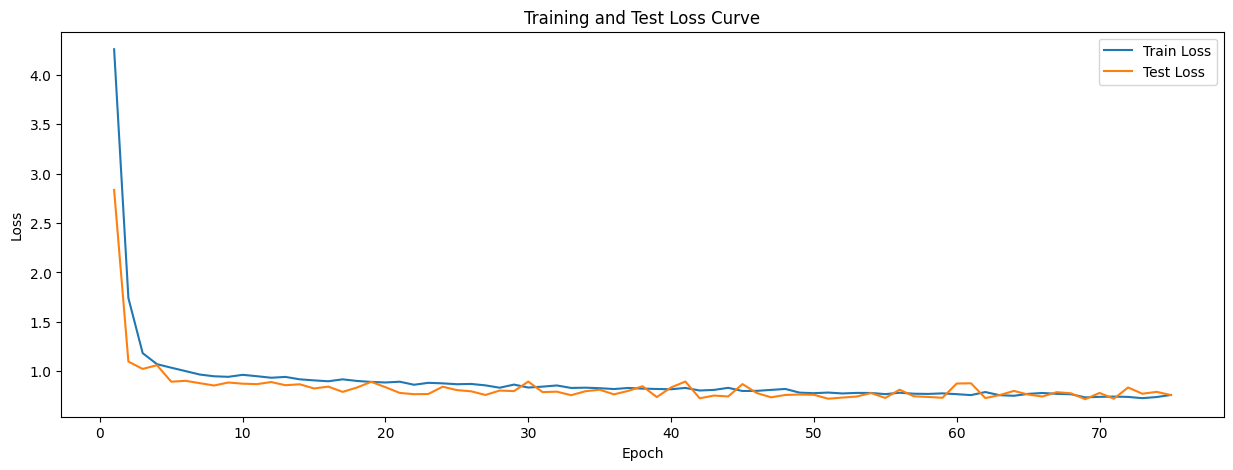

In [18]:
#Testing against the test dataset

model = Classifier(n_features=len(cont_columns),
                   targets_classes=[0],
                   rff_on=True,
                   sigma=best_params['sigma'],
                   embed_size=best_params['embed_size'],
                   num_layers=best_params['num_layers'],
                   heads=best_params['heads'],
                   forward_expansion=best_params['forward_expansion'],
                   pre_norm_on=best_params['prenorm_on'],
                   mlp_scale_classification=best_params['mlp_scale_classification'],
                   embedding_dropout=best_params['embedding_dropout'],
                   decoder_dropout=best_params['decoder_dropout'],
                   classification_dropout=best_params['class_drop']
                   ).to(device_in_use) # Instantiate the model
loss_functions = UncertaintyLoss(1)
optimizer = torch.optim.Adam(params=model.parameters(), lr = best_params['learning_rate']) # Maybe try messing around with optimizers. try other torch optimizers with different configurations.
epochs = 75 #Set the number of epochs

train_losses = []
train_accuracies_1 = [] 
train_accuracies_2 = []
train_recalls = [] 
train_f1_scores = [] 
test_losses = []
test_accuracies_1 = []
test_accuracies_2 = []
test_recalls = []  
test_f1_scores = [] 
all_attention_scores = []

for t in range(epochs):
  train_loss, r2_train, rmse_train = train(train_dataloader, model, loss_functions, optimizer, device_in_use=device_in_use)
  test_loss, r2_test, rmse_test = test(test_dataloader, model, loss_functions, device_in_use=device_in_use)
  train_losses.append(train_loss)

  # train_accuracies_2.append(train_accuracy_2)
  # train_recalls.append(train_recall) 
  # train_f1_scores.append(train_f1)
  test_losses.append(test_loss)

  # test_accuracies_2.append(test_accuracy_2)
  # test_recalls.append(test_recall)
  # test_f1_scores.append(test_f1)
  # Formatting for easier reading
  epoch_str = f"Epoch [{t+1:2}/{epochs}]"
  train_metrics = f"Train: Loss {format_metric(train_loss)}, R2 {format_metric(r2_train)}, RMSE {format_metric(rmse_train)}"
  test_metrics = f"Test: Loss {format_metric(test_loss)}, R2 {format_metric(r2_test)}, RMSE {format_metric(rmse_test)}"
  print(f"{epoch_str:20} | {train_metrics:65} | {test_metrics}")


torch.save(model.state_dict(), 'final_model_trained.pth')

# Plotting the loss curves
plt.figure(figsize=(15, 5))
plt.subplot(1, 1, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), [l for l in test_losses], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()
